In [1]:
import math #it is used for mathematical tasks
import numpy as np #NumPy is a Python library used for working with arrays.
import pandas as pd #Pandas is a Python library used for working with data sets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt #it is a collection of functions that make matplotlib work like MATLAB.
import tensorflow as tf #it is mainly used for: Classification, Perception, Understanding, Discovering, Prediction and Creation.
import keras #it provides a interface for creating deep learning models and wraps the more technical TensorFlow and Theano backends.


In [2]:
df = pd.read_csv('AzureReadings_at_a_timestamp1.csv') #load csv into a DataFrame,DataFrame is a 2 dimensional data structure, like a 2D array
df['timestamp'] =  pd.to_datetime(df['timestamp']) #Convert argument to datetime
df = df.set_index('timestamp')#Set the DataFrame index using existing columns
df.head() #return only the headers and the first 5 rows

,norm_min_cpu,norm_max_cpu,norm_avg
timestamp,,,
2017-01-01 00:00:00,0.2283,0.2346,0.2314
2017-01-01 00:05:00,0.2023,0.2282,0.2152
2017-01-01 00:10:00,0.2120,0.2286,0.2203
2017-01-01 00:15:00,0.1809,0.2137,0.1973
2017-01-01 00:20:00,0.1807,0.2114,0.1960


In [3]:
dataset = df.values #copy the value of df in dataset
dataset = dataset.astype('float32') #convert values to floating point values which are more suitable for modeling with a neural network.

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1)) #This estimator scales and translates each feature individually such that it is in the given range on the training set
dataset = scaler.fit_transform(dataset) #fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data

In [5]:
train_size = int(len(dataset) * 0.8) # split into train and test sets
test_size = len(dataset) - train_size #length of test size data
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

6912 1728


In [6]:
def create_training_dataset(dataset, look_back=1): # convert an array of values into a dataset matrix
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :3]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [7]:
look_back = 5 # reshape dataset
trainX, trainY = create_training_dataset(train, look_back=look_back)
testX, testY = create_training_dataset(test, look_back=look_back)

In [8]:
trainX.shape #shape method returns a tuple denoting the dimensions of a Python object on which it is applied.

(6906, 5, 3)

In [9]:
model = keras.models.Sequential() # create and fit Multilayer Perceptron model
model.add(keras.layers.LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(keras.layers.Dense(3))

In [10]:
adamOpt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adamOpt, metrics=['mae'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               67584     
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 67,971
Trainable params: 67,971
Non-trainable params: 0
_________________________________________________________________


In [12]:
# callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(trainX, trainY, validation_split=0.2,epochs=20, batch_size=64, verbose=2)

Epoch 1/20
87/87 - 2s - loss: 0.0053 - mae: 0.0444 - val_loss: 7.2810e-04 - val_mae: 0.0212
Epoch 2/20
87/87 - 1s - loss: 9.0326e-04 - mae: 0.0203 - val_loss: 6.3821e-04 - val_mae: 0.0200
Epoch 3/20
87/87 - 1s - loss: 8.2442e-04 - mae: 0.0192 - val_loss: 5.8483e-04 - val_mae: 0.0189
Epoch 4/20
87/87 - 1s - loss: 7.7593e-04 - mae: 0.0184 - val_loss: 6.0351e-04 - val_mae: 0.0195
Epoch 5/20
87/87 - 1s - loss: 7.4379e-04 - mae: 0.0180 - val_loss: 5.8767e-04 - val_mae: 0.0188
Epoch 6/20
87/87 - 1s - loss: 7.0698e-04 - mae: 0.0175 - val_loss: 5.3778e-04 - val_mae: 0.0179
Epoch 7/20
87/87 - 1s - loss: 6.8142e-04 - mae: 0.0171 - val_loss: 5.7186e-04 - val_mae: 0.0190
Epoch 8/20
87/87 - 1s - loss: 6.6325e-04 - mae: 0.0170 - val_loss: 5.2405e-04 - val_mae: 0.0177
Epoch 9/20
87/87 - 1s - loss: 6.3952e-04 - mae: 0.0168 - val_loss: 5.0729e-04 - val_mae: 0.0175
Epoch 10/20
87/87 - 1s - loss: 6.0258e-04 - mae: 0.0162 - val_loss: 4.7982e-04 - val_mae: 0.0170
Epoch 11/20
87/87 - 1s - loss: 5.8580e-04 -

In [13]:
model.evaluate(testX, testY)

54/54 [==============================] - 0s 3ms/step - loss: 5.0142e-04 - mae: 0.0157


[0.0005014230264350772, 0.015713956207036972]

In [14]:
model.metrics_names

['loss', 'mae']

In [15]:
trainPredict = model.predict(trainX) # generate predictions for training
testPredict = model.predict(testX)

In [16]:
trainY = scaler.inverse_transform(trainY)
trainPredict = scaler.inverse_transform(trainPredict)
testY = scaler.inverse_transform(testY)
testPredict = scaler.inverse_transform(testPredict)

In [18]:
from sklearn.metrics import mean_squared_error
trainScore=mean_squared_error(trainY[:], trainPredict[:])
print('Train Score: %.6f MSE' %(trainScore))
testScore=mean_squared_error(testY[:], testPredict[:])
print('Test Score: %.6f MSE' %(testScore))

Train Score: 0.000429 MSE
Test Score: 0.000455 MSE


In [20]:
trainScore = math.sqrt(mean_squared_error(trainY[:], trainPredict[:])) # Estimate model performance
print('Train Score: %.6f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[:], testPredict[:]))
print('Test Score: %.6f RMSE' % (testScore))


Train Score: 0.020723 RMSE
Test Score: 0.021334 RMSE


In [21]:
from sklearn.metrics import mean_absolute_error
trainScore = (mean_absolute_error(trainY[:], trainPredict[:]))
print('Train Score: %.6f MAE' % (trainScore))
testScore = math.sqrt(mean_absolute_error(testY[:], testPredict[:]))
print('Test Score: %.6f MAE' % (testScore))

Train Score: 0.014304 MAE
Test Score: 0.121804 MAE


In [22]:
trainScore2 = np.mean(np.abs(trainPredict - trainY)/np.abs(trainY))
print('Train Score: %.6f MAPE' % (trainScore2))
testScore2 = np.mean(np.abs(testPredict - testY)/np.abs(testY))
print('Test Score: %.6f MAPE' % (testScore2))

Train Score: inf MAPE
Test Score: 0.060186 MAPE


C:\Users\91956\AppData\Local\Temp/ipykernel_19216/174757105.py:1: RuntimeWarning: divide by zero encountered in true_divide
  trainScore2 = np.mean(np.abs(trainPredict - trainY)/np.abs(trainY))


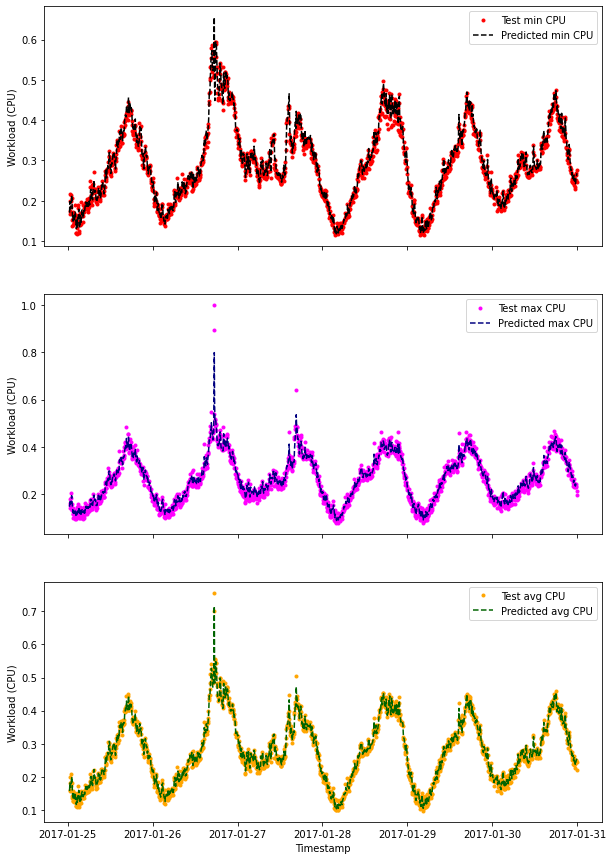

In [23]:
index=df.index
TestY= pd.DataFrame(testY,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(testPredict,columns=['min_cpu','max_cpu','avg_cpu'])

x=index[-1722:]
fig, axs = plt.subplots(3,figsize=(10,15)) # plot baseline and predictions

axs[0].plot(x,TestY.min_cpu,'.',label='Test min CPU',color='red')
axs[0].plot(x,PredY.min_cpu,'--',label='Predicted min CPU',color='black')
axs[0].legend()
axs[1].plot(x,TestY.max_cpu,'.',label='Test max CPU',color='magenta')
axs[1].plot(x,PredY.max_cpu,'--',label='Predicted max CPU',color='navy')
axs[1].legend()
axs[2].plot(x,TestY.avg_cpu,'.',label='Test avg CPU',color='orange')
axs[2].plot(x,PredY.avg_cpu,'--',label='Predicted avg CPU',color='darkgreen')
axs[2].legend()
for ax in axs.flat:
    ax.set(xlabel='Timestamp', ylabel='Workload (CPU)',autoscale_on=True)
for ax in axs:
    ax.label_outer()
#fig.suptitle('Prediction of Workload on Azure cloud at a particular timestamp',fontsize=20)
plt.savefig('gru_output.png', dpi = 300)
plt.show()